# Práctica No. 1: K-means y Detección de Anomalías
**José Barrios - 20007192**

In [29]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import f1_score
from scipy.stats import multivariate_normal

## Parte 1: Clustering
* Utilizar los datos del archivo estaturas (primera pestaña) para implementar:
    * Hard-clustering con k-means (no usar sklearn)
    * Soft-clustering con GMM usando sklearn
* Ejecutar al menos 5 experimentos para seleccionar el valor de “K”
    * Ambos métodos pueden usar el mismo valor de “K”
    * Analizar el centroide de cada clúster y determinar si es posible asignar una categoría  cada clúster
* Analizar y concluir si el método del codo es adecuado para este problema
* Usar los datos en la segunda pestaña y estimar:
    * El clúster que k-means asigna cada uno.
    * La probabilidad de pertenecer a cada clúster según GMM

In [45]:
data_train = pd.read_excel('estaturas.xlsx', sheet_name='normales')
data_test = pd.read_excel('estaturas.xlsx', sheet_name='valtest(normales)')
data_anomalias = pd.read_excel('estaturas.xlsx', sheet_name='anomalias')
data_train.head()

,Estatura,Edad
0,1.77,26
1,1.74,31
2,1.72,24
3,1.78,34
4,1.65,32


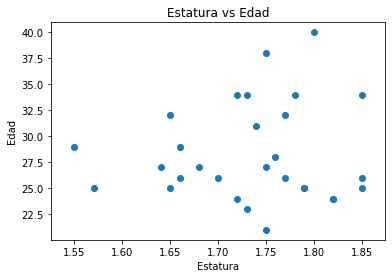

In [3]:
plt.scatter(data_train['Estatura'], data_train['Edad'])
plt.title("Estatura vs Edad")
plt.xlabel("Estatura")
plt.ylabel("Edad")
plt.show()

### K-Means
Implementación sin sklearn

In [14]:
#Para mostrar colores en los gráficos
color=['red','blue','yellow','cyan','magenta', 'green', 'black', 'orange']

In [13]:
def kMeans(df, k, imprimir_centros_aleatorios=True, seed=1234):
    np.random.seed(seed)
    data = df.to_numpy()
    m, c = data.shape

    #Generar k centros aleatorios
    mean = np.mean(data, axis = 0)
    std = np.std(data, axis = 0)
    centers = np.random.randn(k, c) * std + mean
    
    #Imprimir centros aleatorios iniciales si así lo desea el usuario (y si es de grado 2)
    if(c == 2 and imprimir_centros_aleatorios == True):
        plt.scatter(data[:, 0], data[:, 1], s=7)
        plt.scatter(centers[:,0], centers[:,1], marker='*', c='g', s=150)
        plt.title('Centroides aleatorios para k=' + str(k))
        plt.show()
        
    #Almacenar nuevos y antiguos k centros centros
    centers_old = np.zeros(centers.shape)
    centers_new = copy.deepcopy(centers)
    
    #Tensores de clusters y distancias a cada centro
    clusters = np.zeros(m)
    distances = np.zeros((m,k))
    
    #Distancia de primera iteración
    diff = np.linalg.norm(centers_new - centers_old)
    
    #Ciclo que termina cuando los centros ya no se mueven o se llega al límite early-stop
    epoch = 0
    while diff != 0 and epoch < 20:
        #Medir la distancia a cada centro
        for i in range(k):
            distances[:,i] = np.linalg.norm(data - centers[i], axis=1)
        #Asignar la data a su cluster más cercano
        clusters = np.argmin(distances, axis = 1)

        centers_old = copy.deepcopy(centers_new)
        #Calcular la media de cada punto asignado a cada centro para calcular el nuevo centro
        for i in range(k):
            centers_new[i] = np.mean(data[clusters == i], axis=0)
        diff = np.linalg.norm(centers_new - centers_old)
        epoch = epoch + 1
    
    #Mostrar resultado final
    if(c == 2 and k < len(color) + 1):
        for i in range(m):
            plt.scatter(data[i,0], data[i,1], s=15, c=color[clusters[i]])
        for i in range(k):
            plt.scatter(centers_new[i,0], centers_new[i,1], marker='*', c=color[i], s=150)
        plt.title('Centroides finales para k=' + str(k))
        plt.show()    

    return centers_new, clusters, np.min(distances, axis=1).mean() #Distorción final

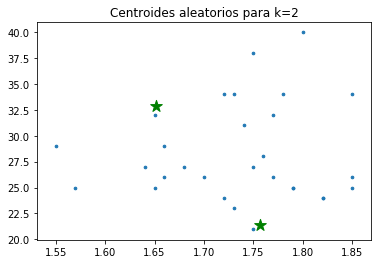

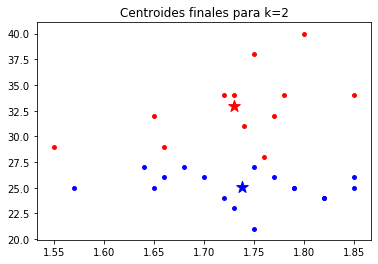

(array([[ 1.73      , 32.91666667],
        [ 1.73764706, 25.05882353]]),
 array([1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 1], dtype=int64),
 3.323670303533087)

In [5]:
kMeans(data_train, 2, seed=123)

Ejecución de al menos 5 expermientos para determinar la mejor k con la data de entrenamiento.

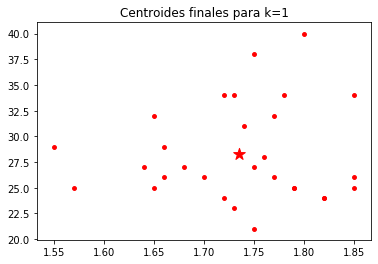

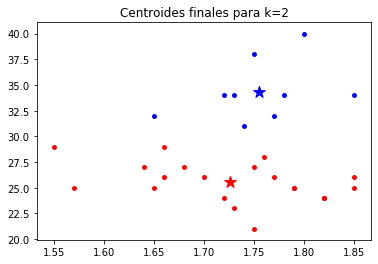

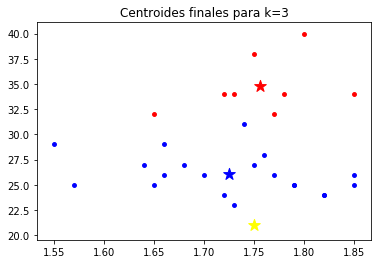

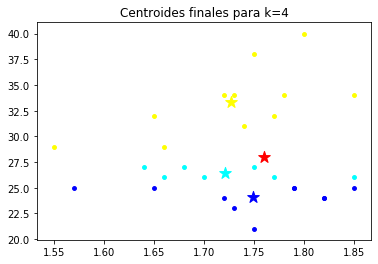

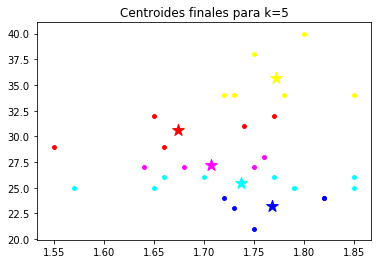

D:\Programs\Anaconda\envs\clase22\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Programs\Anaconda\envs\clase22\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


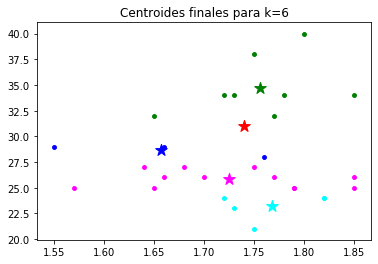

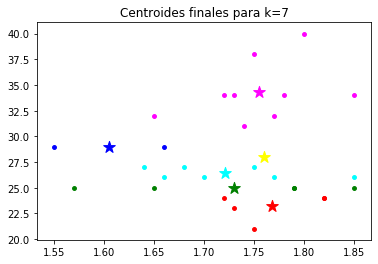

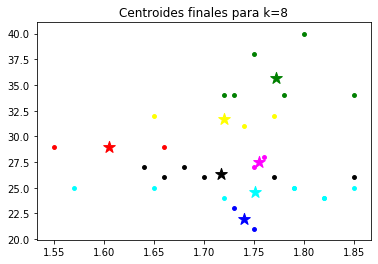

In [6]:
errores = []
for i in range(1, 9):
    _, _, distorsion = kMeans(data_train, i, imprimir_centros_aleatorios=False, seed = 123 + i)
    errores.append(distorsion)

In [7]:
errores

[3.6181318745260946,
 3.3931017732446884,
 2.826051489656088,
 2.293004886671194,
 1.265786537055346,
 1.2830758604157624,
 1.197869407418754,
 0.9589612395567135]

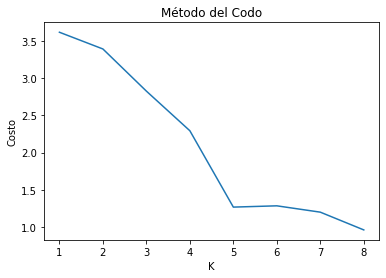

In [8]:
plt.plot(range(1, len(errores) + 1), errores)
plt.title('Método del Codo')
plt.xlabel('K')
plt.ylabel('Costo')
plt.show()

Notamos que el error deja de disminuir significativamente luego de k=5, por lo que seleccionamos esta como la cantidad de centroides.

Ahora realizaremos una estimación de a qué cluster debe ser asignado cada dato de validación.

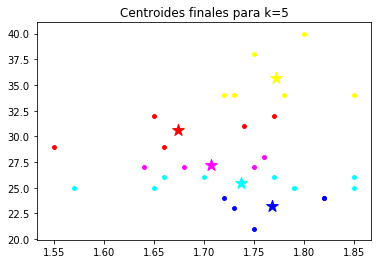

In [9]:
centros, _, _ = kMeans(data_train, 5, imprimir_centros_aleatorios=False, seed = 128)

In [17]:
def kAsignation(df, k, centers):
    data = df.to_numpy()
    m = data.shape[0]
    distances = np.zeros((m,k))
    
    #Distancia a cada centroide
    for i in range(k):
        distances[:,i] = np.linalg.norm(data - centers[i], axis=1)
    
    #Asignar al centroide más cercano
    clusters = np.argmin(distances, axis = 1) 
    
    #Graficar centroides y data
    for i in range(m):
        plt.scatter(data[i,0], data[i,1], s=15, c=color[clusters[i]])
    for i in range(k):
        plt.scatter(centers[i,0], centers[i,1], marker='*', c=color[i], s=150)
    plt.title('Centroides y data_test')
    plt.show()
    
    return clusters

In [11]:
data_test

,Estatura,Edad
0,1.82,25
1,1.80,27
2,1.60,31
3,1.60,35
4,1.82,30
5,1.76,32
6,1.79,31
7,1.61,31


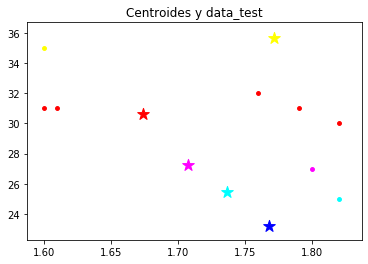

array([3, 4, 0, 2, 0, 0, 0, 0], dtype=int64)

In [18]:
asignacion_test = kAsignation(data_test, 5, centros)
asignacion_test

#### Observaciones
La mayoría de datos de testing fueron asignados al cluster rojo, el cual comprende entre los 30 y 32 años.
 
Es de notar que la edad fue la característica que más peso tuvo al momento de crear los clusters, se pueden ver límites claros entre los rangos de edad.
 
<img src="kmeans.png">

### GMM
Soft clustering implementado con sklearn

In [19]:
modelo_gm = GaussianMixture(n_components = 5).fit(data_train)
etiquetas = modelo_gm.predict(data_train)

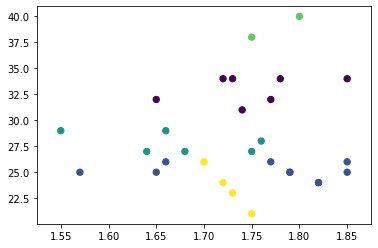

In [21]:
plt.scatter(data_train["Estatura"], data_train["Edad"], c = etiquetas, s = 40, cmap = 'viridis')
plt.show()

In [28]:
etiquetas_test = modelo_gm.predict(data_test)
prob_test = modelo_gm.predict_proba(data_test)
print(prob_test.round(4))

[[0.     0.9481 0.0519 0.     0.    ]
 [0.     0.0794 0.9206 0.     0.    ]
 [0.8654 0.     0.1346 0.     0.    ]
 [1.     0.     0.     0.     0.    ]
 [0.9819 0.     0.0181 0.     0.    ]
 [1.     0.     0.     0.     0.    ]
 [1.     0.     0.     0.     0.    ]
 [0.9192 0.     0.0808 0.     0.    ]]


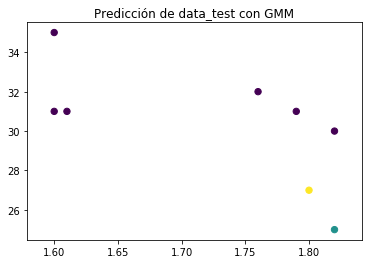

In [26]:
plt.scatter(data_test["Estatura"], data_test["Edad"], c = etiquetas_test, s = 40, cmap = 'viridis')
plt.title("Predicción de data_test con GMM")
plt.show()

Notamos que GMM creó clusters similares -con unas dos observaciones que quedaron diferentes de k Means-, y que con la data de prueba todas las observaciones fueron asignadas a clusters equivalentes de k means.

## Parte2: Detección de anomalías
* Usar pestaña uno para hacer el entrenamiento del modelo de detección de anomalías.
* Usar pestaña dos y tres como set de validación(seleccionar epsilon) y pruebas.

In [46]:
np_data_train = np.array(data_train) #Training
np_data_cv = np.array(data_test) #Cross validation
np_data_anomalias = np.array(data_anomalias) #Anomalías

In [99]:
#Crear arreglos etiquetando las anomalías como 1 y las observaciones normales de 0
data_stack = np.vstack((np_data_cv, np_data_anomalias))
gt_stack = np.hstack((np.zeros_like(np_data_cv[:,0]), np.ones_like(np_data_anomalias[:,0])))

In [100]:
gt_stack

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.])

In [32]:
def estimateGaussian(data):
    mu = np.mean(data, axis=0)
    sigma = np.cov(data.T)
    return mu, sigma

In [33]:
#Función de detección de anomalías
def multivariateGaussian(data, mu, sigma):
    p = multivariate_normal(mu, sigma)
    return p.pdf(data)

In [34]:
#Seleccion de umbral 
#Basa su selección de epsilon al recibir un arreglo etiquetando observaciones normales y anormales
def ThresholdSelection(probs, gt):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    step_size = (max(probs) - min(probs)) / 1000
    epsilons = np.arange(min(probs), max(probs), step_size)
    
    for epsilon in np.nditer(epsilons):
        predictions = (probs < epsilon)
        f = f1_score(gt, predictions, average = "binary")
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon
    return best_f1, best_epsilon

In [101]:
mu, sigma = estimateGaussian(np_data_train)
p = multivariateGaussian(np_data_train, mu, sigma)

p_cv =  multivariateGaussian(data_stack, mu, sigma)
fscore, epsilon = ThresholdSelection(p_cv, gt_stack)

In [102]:
print(fscore)
print(epsilon)

1.0
0.00030826203445742336


In [63]:
#Función para graficar las anomalías obtenidas
def grafica_gauss(epsilon, data, pdf):
    plt.scatter(data[:,0], data[:,1], marker="x",c=pdf, cmap='viridis');
    outliers = np.nonzero(pdf < epsilon)[0]
    plt.scatter(data[outliers,0], data[outliers,1], marker="o", facecolor="none", edgecolor="red",s=75)
    return outliers

array([], dtype=int64)

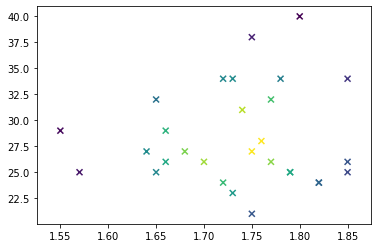

In [103]:
grafica_gauss(epsilon, np_data_train, p)

> Las observaciones normales se pintan con una x y las anomalías (u outliers) se les encierra con un circulo.

In [104]:
p_anomalia =  multivariateGaussian(np_data_anomalias, mu, sigma)

array([0, 1, 2, 3], dtype=int64)

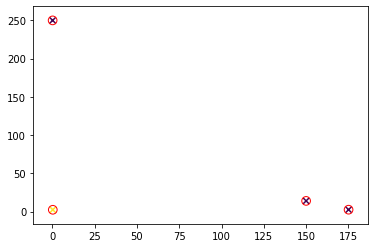

In [105]:
grafica_gauss(epsilon_tr, np_data_anomalias, p_anomalia)

### Observaciones
Definimos una función que selecciona el umbral al etiquetar previamente cuáles observaciones son normales y cuáles son outliers. Este proceso nos devuelve un **epsilon de 0.003** y notamos que la data de entrenamiento la logra etiquetar correctamente como normal y, las que deben ser outliers, como anormales.